In [1]:
%load_ext autoreload
%autoreload 2

In [95]:
import tensorflow as tf
from tensorflow import keras
from toai.imports import *

from data import DataContainer
from image import *
from image_learner import ImageLearner
from transformations import ImageParser, ImageCropTransformation, ImageRandomCropTransformation, ImageLRFlpTransformation

from sklearn.metrics import classification_report, confusion_matrix
import metrics

In [5]:
tf.debugging.set_log_device_placement(False)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            print(gpu)
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


In [6]:
DATA_DIR = Path('data')
TEMP_DIR = Path('temp')
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [32]:
df = pd.read_csv('train.csv', low_memory=False)
labels = pd.read_csv('labels.csv')

In [33]:
df = pd.merge(df, labels, left_on='category_id', right_on='id')
df.drop(columns='id_y', inplace=True)

In [34]:
df.head().T

,0,1,2,3,4
category_id,19,19,19,19,19
date_captured,2011-05-13 23:43:18,2012-03-17 03:48:44,2012-05-07 23:17:19,2010-06-04 01:32:16,2010-10-07 20:14:32
file_name,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,588a679f-23d2-11e8-a6a3-ec086b02610b.jpg,5883e97b-23d2-11e8-a6a3-ec086b02610b.jpg,58d47cf1-23d2-11e8-a6a3-ec086b02610b.jpg,58d15f82-23d2-11e8-a6a3-ec086b02610b.jpg
frame_num,1,2,1,4,2
id_x,5998cfa4-23d2-11e8-a6a3-ec086b02610b,588a679f-23d2-11e8-a6a3-ec086b02610b,5883e97b-23d2-11e8-a6a3-ec086b02610b,58d47cf1-23d2-11e8-a6a3-ec086b02610b,58d15f82-23d2-11e8-a6a3-ec086b02610b
location,33,115,78,100,100
rights_holder,Justin Brown,Justin Brown,Justin Brown,Justin Brown,Justin Brown
seq_id,6f084ccc-5567-11e8-bc84-dca9047ef277,6f12067d-5567-11e8-b3c0-dca9047ef277,6f1c553d-5567-11e8-9f6c-dca9047ef277,6f1d1eeb-5567-11e8-92ef-dca9047ef277,6f1d875c-5567-11e8-af6d-dca9047ef277
seq_num_frames,3,3,3,5,3
width,1024,1024,1024,1024,1024


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196299 entries, 0 to 196298
Data columns (total 11 columns):
category_id       196299 non-null int64
date_captured     196299 non-null object
file_name         196299 non-null object
frame_num         196299 non-null int64
id                196299 non-null object
location          196299 non-null int64
rights_holder     196299 non-null object
seq_id            196299 non-null object
seq_num_frames    196299 non-null int64
width             196299 non-null int64
height            196299 non-null int64
dtypes: int64(6), object(5)
memory usage: 16.5+ MB


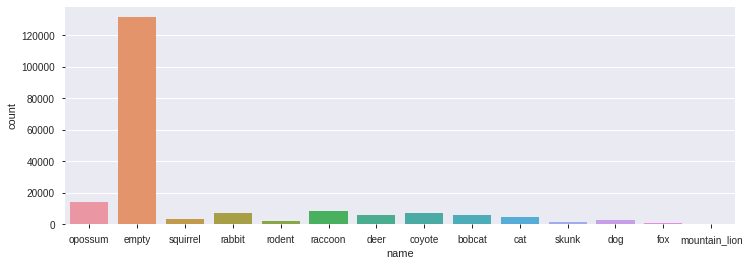

In [36]:
plt.figure(figsize=(12,4))
sns.countplot(x='name', data=df);

In [45]:
df['name'].value_counts()

empty            131457
opossum           14106
raccoon            8623
coyote             7209
rabbit             6938
deer               6102
bobcat             5975
cat                4759
squirrel           3398
dog                3035
rodent             2210
skunk              1361
fox                1093
mountain_lion        33
Name: name, dtype: int64

In [46]:
df['path'] = df['file_name'].apply(lambda fn : str(DATA_DIR/'train'/fn))

In [47]:
df.head(1)

,category_id,date_captured,file_name,frame_num,id_x,location,rights_holder,seq_id,seq_num_frames,width,height,name,path
0,19,2011-05-13 23:43:18,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,1,5998cfa4-23d2-11e8-a6a3-ec086b02610b,33,Justin Brown,6f084ccc-5567-11e8-bc84-dca9047ef277,3,1024,747,opossum,data/train/5998cfa4-23d2-11e8-a6a3-ec086b02610...


In [48]:
def create_class_weight_map(df: pd.DataFrame, class_name: str):
    classes = np.unique(df[class_name])
    weights = sklearn.utils.class_weight.compute_class_weight('balanced', classes, df[class_name])
    
    return { key: value for key, value in zip(classes, weights) }

In [49]:
train_data, validation_data = train_test_split(df, test_size=0.4, stratify=df['name'])

In [50]:
validation_data, test_data = train_test_split(validation_data, test_size=0.5, stratify=validation_data['name'])

In [51]:
[data.shape for data in (train_data, validation_data, test_data)]

[(117779, 13), (39260, 13), (39260, 13)]

In [52]:
IMG_DIMS = (100, 100, 3)

In [53]:
class_weights = create_class_weight_map(train_data, 'name'); class_weights

{'bobcat': 2.3466626818091254,
 'cat': 2.9466850137603204,
 'coyote': 1.9451527663088357,
 'deer': 2.2979474772700668,
 'dog': 4.619871342276614,
 'empty': 0.10666107607431745,
 'fox': 12.824368466898955,
 'mountain_lion': 420.63928571428573,
 'opossum': 0.9940666092739825,
 'rabbit': 2.0208469167152807,
 'raccoon': 1.6259732729581975,
 'rodent': 6.344483947425124,
 'skunk': 10.29716733694702,
 'squirrel': 4.125937084004764}

In [75]:
base_config = ImageDatasetConfig(
    img_dims=IMG_DIMS,
    batch_size=32,
    preprocess_pipeline=[
        ImageParser(),
        ImageCropTransformation(IMG_DIMS)
    ],
)

train_dataset = ImageDataset(base_config.copy(
        preprocess_pipeline=[
            ImageLRFlpTransformation()
        ],
        shuffle=True,
    )).build_from_df(train_data, 'path', 'name')

data_container = DataContainer(
    train=train_dataset,
    validation=ImageDataset(base_config.copy(
        preprocess_pipeline = [
            ImageLRFlpTransformation(),
        ],
    )).with_label_map(train_dataset.label_map).build_from_df(validation_data, 'path', 'name'),
    test=ImageDataset(base_config.copy(
        preprocess_pipeline=[
#             ImageCropTransformation(IMG_DIMS)
        ],
    )).with_label_map(train_dataset.label_map).build_from_df(test_data, 'path', 'name'),
)

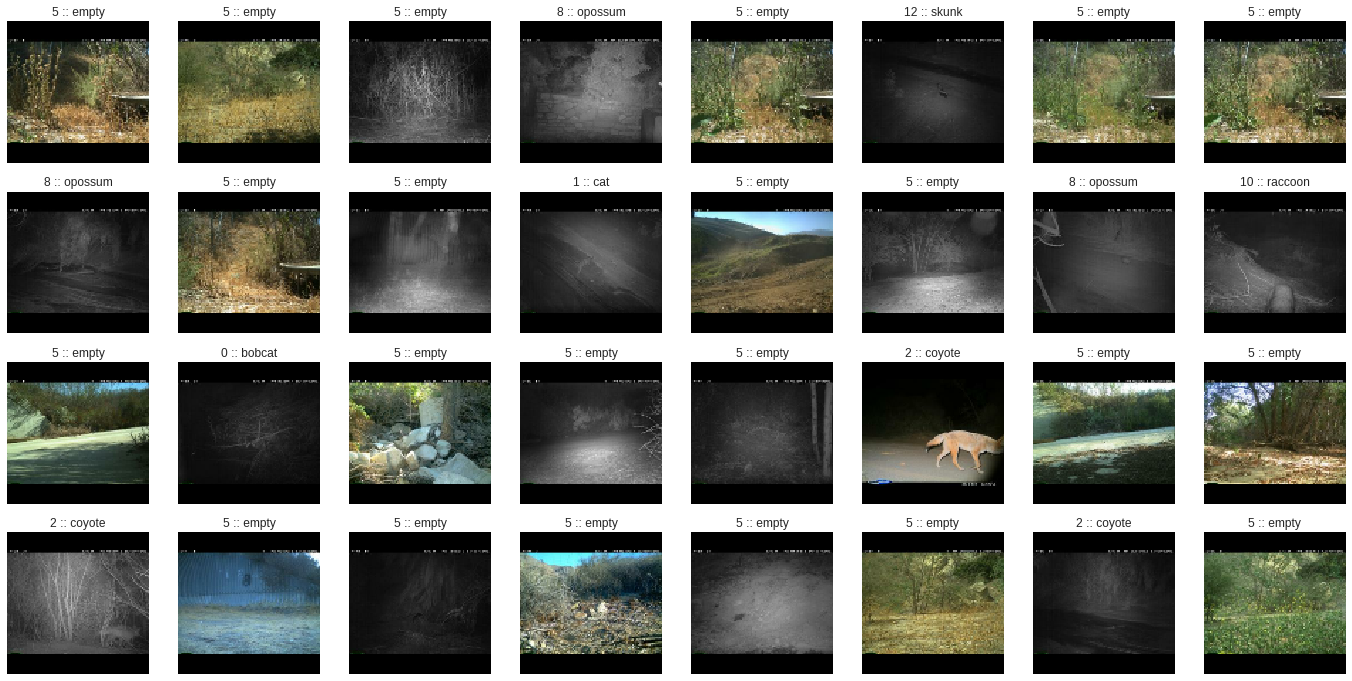

In [56]:
data_container.train.show()

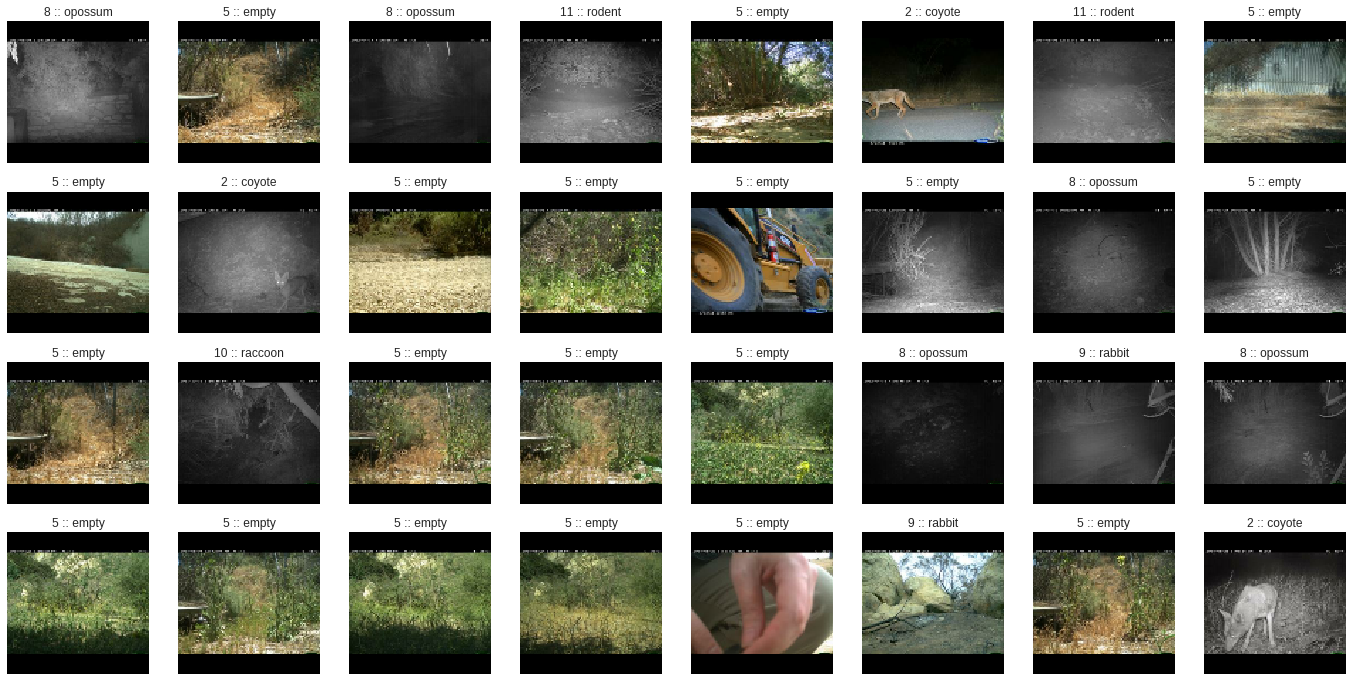

In [76]:
data_container.test.show()

In [78]:
learner = ImageLearner(
    model_path=Path('xception'),
    data=data_container,
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    activation=keras.activations.softmax,
    dropout=0.1,
)

Existing model data path exists
Loading architecture and weights from xception
Model loaded successfully


In [79]:
learner.auto_train(
    easing_epochs=0,
    epochs=0,
    optimizer=keras.optimizers.Adam,
    lr=1e-3,
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=[keras.metrics.sparse_categorical_accuracy],
)

Starting model training
Train for 3681 steps, validate for 1227 steps
Loading weights only from xception/weights.h5
Model loaded successfully
Model training completed


In [66]:
history = learner.auto_train(
    easing_epochs=0,
    epochs=5,
    optimizer=keras.optimizers.Adam,
    lr=1e-3,
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=[keras.metrics.sparse_categorical_accuracy],
)

Starting model training
Train for 3681 steps, validate for 1227 steps
Epoch 1/5
3681/3681 [==============================] - 346s 94ms/step - loss: 0.5540 - sparse_categorical_accuracy: 0.8372 - val_loss: 1.2327 - val_sparse_categorical_accuracy: 0.8633
Epoch 2/5
3681/3681 [==============================] - 343s 93ms/step - loss: 0.3808 - sparse_categorical_accuracy: 0.8795 - val_loss: 0.3441 - val_sparse_categorical_accuracy: 0.8867
Epoch 3/5
3681/3681 [==============================] - 345s 94ms/step - loss: 0.5107 - sparse_categorical_accuracy: 0.8593 - val_loss: 0.3369 - val_sparse_categorical_accuracy: 0.8911
Epoch 4/5
3681/3681 [==============================] - 338s 92ms/step - loss: 0.2991 - sparse_categorical_accuracy: 0.9053 - val_loss: 0.3144 - val_sparse_categorical_accuracy: 0.9007
Epoch 5/5
3681/3681 [==============================] - 340s 92ms/step - loss: 0.2703 - sparse_categorical_accuracy: 0.9147 - val_loss: 0.2917 - val_sparse_categorical_accuracy: 0.9081
Loading we

In [80]:
learner.evaluate_dataset(mode='test', verbose=1)

1227/1227 [==============================] - 27s 22ms/step - loss: 1.5058 - sparse_categorical_accuracy: 0.5592


[1.5057656969495585, 0.5591951]

In [81]:
predictions = learner.predict_dataset(mode='test', verbose=1)

1227/1227 [==============================] - 26s 21ms/step


In [82]:
pred = np.argmax(predictions, axis=1)

In [88]:
lm = data_container.train.label_map
trues = test_data['name'].apply(lambda n : lm[n])

In [97]:
print(classification_report(trues, pred))

              precision    recall  f1-score   support

           0       0.22      0.11      0.15      1195
           1       0.13      0.07      0.10       952
           2       0.15      0.35      0.21      1442
           3       0.47      0.57      0.51      1220
           4       0.07      0.44      0.11       607
           5       0.86      0.70      0.77     26292
           6       0.08      0.02      0.04       219
           7       0.00      0.00      0.00         6
           8       0.49      0.25      0.33      2821
           9       0.10      0.23      0.13      1388
          10       0.36      0.46      0.40      1725
          11       0.06      0.01      0.02       442
          12       0.17      0.38      0.23       272
          13       0.16      0.09      0.12       679

    accuracy                           0.56     39260
   macro avg       0.24      0.26      0.22     39260
weighted avg       0.67      0.56      0.60     39260

